In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utility import *
from theoretical import european_call
from scipy.stats import sem, norm


### 6.B
Consider a straddle with strike price $K$ and maturity $T$. The option payoff is
$$X = (S_T - K)^+ + (K - S_T)^+.$$
Write a function to compare the following schemes:

(a) Plain Monte Carlo with sample size $2n$.

(b) Antithetic variates with $n$ pairs of samples.

(c) Control variate method with sample size $2n$. Use the underlying stock price as the control variate. Let $b = \hat{b}^*$.

(d) Stratified sampling with sample size $2n$. Stratify $W_T$ into $k$ strata and use the proportional allocation.

The fuction should have input parameters $S_0, r, \sigma, K, T, k$, and $n$. Report your estimates and standard errors for

$$S_0 = 50, r = 0.02, \sigma=0.2, K = 50, T = 1, k = 100, n = 10,000.$$

Why is the performance from the antithetic sampling and the control variate method poor?

In [16]:
def final_stock_price(S_0, r, sig, T, Z):
    """Simulate final stock price S_T using Geometric Brownian Motion."""
    return S_0 * np.exp((r - 0.5 * sig**2) * T + sig * np.sqrt(T) * Z)

In [43]:
# Setup
np.random.seed(4198)

S_0, r, sig, K, T = 50, 0.02, 0.2, 50, 1

k = 100
n = 10_000

In [50]:
def plain(K):
    """Plain Monte Carlo method."""
    Z = np.random.normal(size=2*n)
    S_T = final_stock_price(S_0, r, sig, T, Z)

    payoffs = np.maximum(S_T - K, 0) + np.maximum(K - S_T, 0)
    discounted_payoffs = np.exp(-r * T) * payoffs

    est = np.mean(discounted_payoffs)
    se = sem(discounted_payoffs)
    re = se / np.abs(est)

    return est, se, re

def antithetic(K):
    """Antithetic variates method."""
    Z = np.random.normal(size=n)
    S_T1 = final_stock_price(S_0, r, sig, T, Z)
    S_T2 = final_stock_price(S_0, r, sig, T, -Z)

    payoffs_1 = np.maximum(S_T1 - K, 0) + np.maximum(K - S_T1, 0)
    payoffs_2 = np.maximum(S_T2 - K, 0) + np.maximum(K - S_T2, 0)
    payoffs = 0.5 * (payoffs_1 + payoffs_2)
    discounted_payoffs = np.exp(-r * T) * payoffs

    est = np.mean(discounted_payoffs)
    se = sem(discounted_payoffs)
    re = se / np.abs(est)

    return est, se, re

def control_variate_underlying(K):
    """Control variate using the underlying asset price S_T."""
    Z = np.random.normal(size=2*n)
    S_T = final_stock_price(S_0, r, sig, T, Z)

    payoffs = np.maximum(S_T - K, 0) + np.maximum(K - S_T, 0)
    discounted_payoffs = np.exp(-r * T) * payoffs

    # Control variate: final stock price S_T
    S_T_discounted = np.exp(-r * T) * S_T
    cov = np.cov(discounted_payoffs, S_T_discounted)[0, 1]
    var_S_T = np.var(S_T_discounted)
    b_opt = cov / var_S_T

    adjusted_payoffs = discounted_payoffs - b_opt * (S_T_discounted - S_0)
    
    est = np.mean(adjusted_payoffs)
    se = sem(adjusted_payoffs)
    re = se / np.abs(est)

    return est, se, re

def stratified_sampling(K):
    """Stratified sampling with proportional allocation."""
    sample_size = 2 * n
    strata_size = sample_size // k
    est_values = []
    se_values = []

    for i in range(k):
        V = np.random.uniform(size=strata_size)
        U = i / k + V / k
        Z = norm.ppf(U)
        
        S_T = final_stock_price(S_0, r, sig, T, Z)
        
        payoffs = np.maximum(S_T - K, 0) + np.maximum(K - S_T, 0)
        discounted_payoffs = np.exp(-r * T) * payoffs

        est_values.append(np.mean(discounted_payoffs))
        se_values.append(sem(discounted_payoffs))
    
    est = np.mean(est_values)
    se = np.sqrt(np.sum(np.array(se_values)**2) / strata_size) / k
    re = se / np.abs(est)

    return est, se, re


In [52]:
# Prepare storage dictionaries
ests = {}
ses = {}
res = {}

# Initialize methods dictionary
methods = {
    "Plain MC": plain,
    "Antithetic": antithetic,
    "Control Variate (Underlying)": control_variate_underlying,
    "Stratified Sampling": stratified_sampling
}

# Run simulations for each method
for method, fn in methods.items():
    est, se, re = fn(K)
    ests[method] = est
    ses[method] = se
    res[method] = f"{re:.3%}"

# Store in a DataFrame
results_df = pd.DataFrame({
    "Estimate": ests,
    "Standard Error": ses,
    "Relative Error": res
})

display(results_df)

,Estimate,Standard Error,Relative Error
Plain MC,7.859188,0.043949,0.559%
Antithetic,7.912965,0.061135,0.773%
Control Variate (Underlying),7.921086,0.041422,0.523%
Stratified Sampling,7.924438,0.000301,0.004%


Correlation coefficient: 0.8549


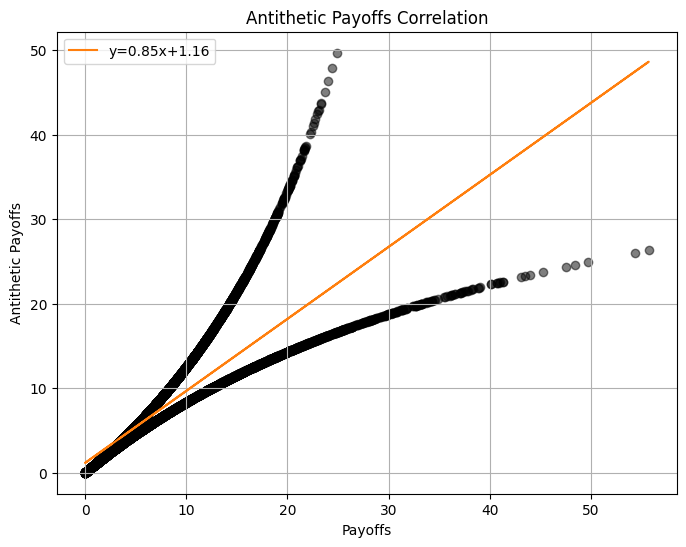

In [54]:
# Antithetic Sampling Analysis
N = 10_000

Z = np.random.normal(0, 1, N)
Z_neg = -Z
S_T = final_stock_price(S_0, r, sig, T, Z)
S_T_neg = final_stock_price(S_0, r, sig, T, Z_neg)

payoffs = np.maximum(S_T - K, 0) + np.maximum(K - S_T, 0)
payoffs_neg = np.maximum(S_T_neg - K, 0) + np.maximum(K - S_T_neg, 0)

beta = np.corrcoef(payoffs, payoffs_neg)[0, 1]
print(f"Correlation coefficient: {beta:.4f}")

# Regress payoffs on payoffs_neg
m, b = np.polyfit(payoffs_neg, payoffs, 1)

# Plot payoffs vs. payoffs_neg
plt.figure(figsize=(8, 6))
plt.scatter(payoffs, payoffs_neg, color='black', alpha=0.5)
plt.plot(payoffs, m * payoffs + b, color='tab:orange', label=f"y={m:.2f}x+{b:.2f}")

plt.title("Antithetic Payoffs Correlation")

plt.xlabel("Payoffs")
plt.ylabel("Antithetic Payoffs")

plt.legend()
plt.grid()

plt.show()


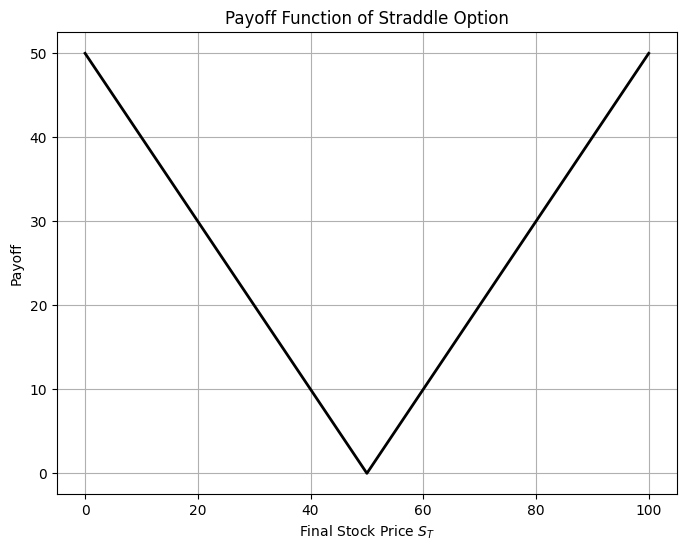

In [59]:
# Payoff Function
X = np.linspace(0, 100, 200 + 1)
payoff = np.maximum(X - K, 0) + np.maximum(K - X, 0)

# Payoff is not monotonic, it is a "V" shape centered at K

# Plot Payoff Function
plt.figure(figsize=(8, 6))
plt.plot(X, payoff, color='black', label='Straddle Payoff', linewidth=2)

plt.title("Payoff Function of Straddle Option")
plt.xlabel("Final Stock Price $S_T$")
plt.ylabel("Payoff")

plt.grid()
plt.show()

Correlation coefficient: 0.3711


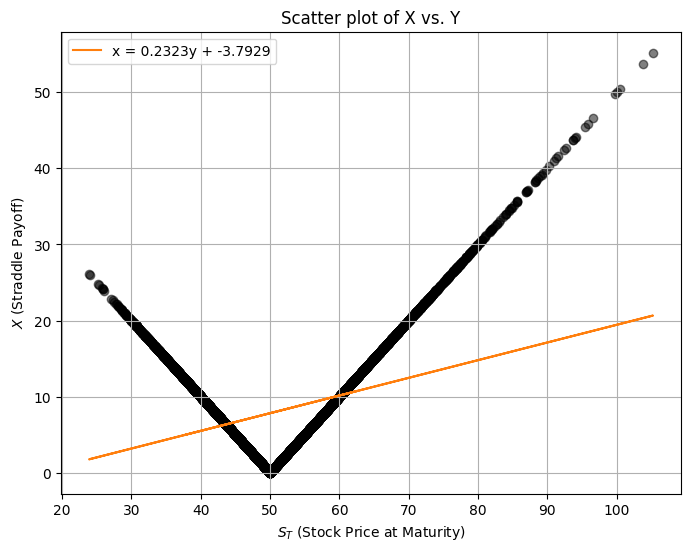

In [55]:
# Control Variate Analysis

Z = np.random.normal(0, 1, N)

S_T = final_stock_price(S_0, r, sig, T, Z)

X1 = np.maximum(S_T - K, 0)
X2 = np.maximum(K - S_T, 0)
X = X1 + X2

Y = S_T

beta = np.corrcoef(X, Y)[0, 1]
print(f"Correlation coefficient: {beta:.4f}")

# regress X on Y with polyfit
m, b = np.polyfit(Y, X, 1)

# Plot X vs. Y
plt.figure(figsize=(8, 6))
plt.scatter(Y, X, alpha=0.5, color='black')
plt.plot(Y, m * Y + b, color='tab:orange', label=f'x = {m:.4f}y + {b:.4f}')

plt.title("Scatter plot of X vs. Y")

plt.xlabel("$S_T$ (Stock Price at Maturity)")
plt.ylabel("$X$ (Straddle Payoff)")

plt.grid()
plt.legend()

plt.show()


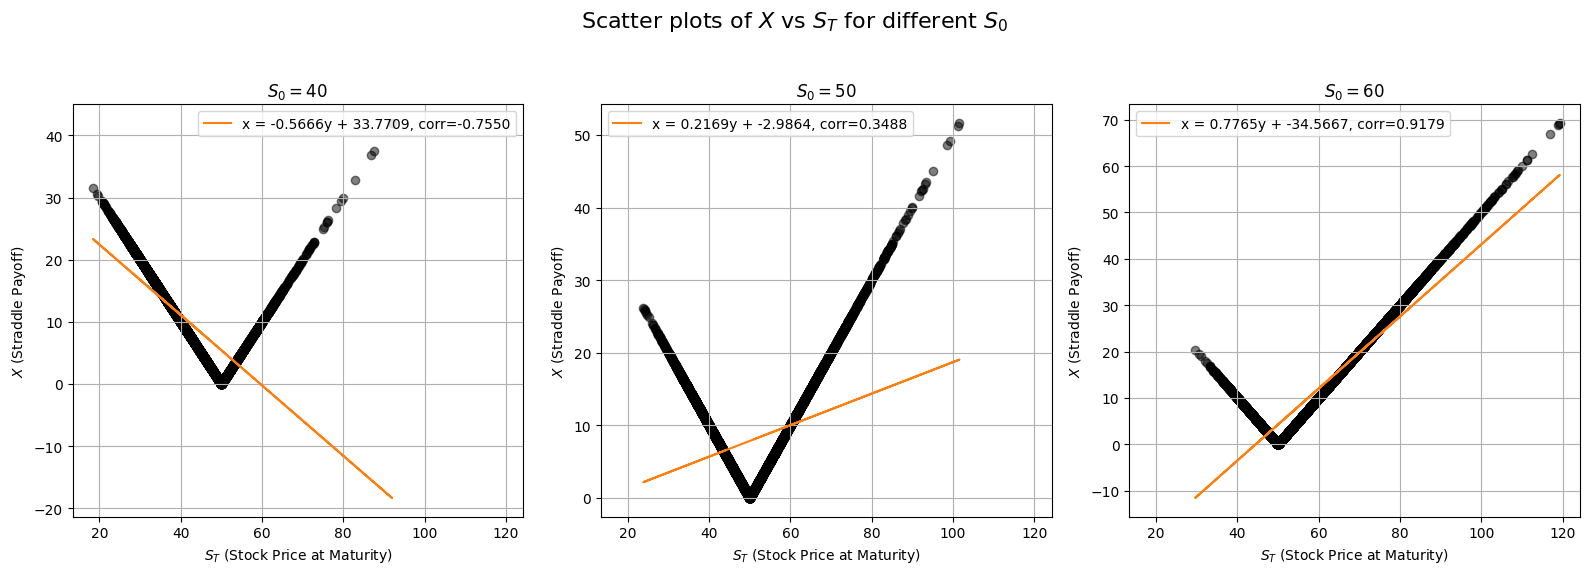

In [18]:
# Parameters
S0_values = [40, 50, 60]

# Create side-by-side subplots
fig, axes = plt.subplots(1, 3, figsize=(16, 6), sharex=True)

for i, S_0 in enumerate(S0_values):
    # Simulate S_T
    Z = np.random.normal(0, 1, N)
    S_T = final_stock_price(S_0, r, sig, T, Z)
    X1 = np.maximum(S_T - K, 0)
    X2 = np.maximum(K - S_T, 0)
    X = X1 + X2
    Y = S_T

    # Correlation
    beta = np.corrcoef(X, Y)[0, 1]

    # Regression
    m, b = np.polyfit(Y, X, 1)
    axes[i].scatter(Y, X, alpha=0.5, color='black')
    axes[i].plot(Y, m * Y + b, color='tab:orange', label=f'x = {m:.4f}y + {b:.4f}, corr={beta:.4f}')
    
    axes[i].set_xlabel('$S_T$ (Stock Price at Maturity)')
    axes[i].set_ylabel('$X$ (Straddle Payoff)')
    
    axes[i].set_title(f'$S_0 = {S_0}$')
    
    axes[i].legend()
    axes[i].grid()

    
plt.suptitle('Scatter plots of $X$ vs $S_T$ for different $S_0$', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


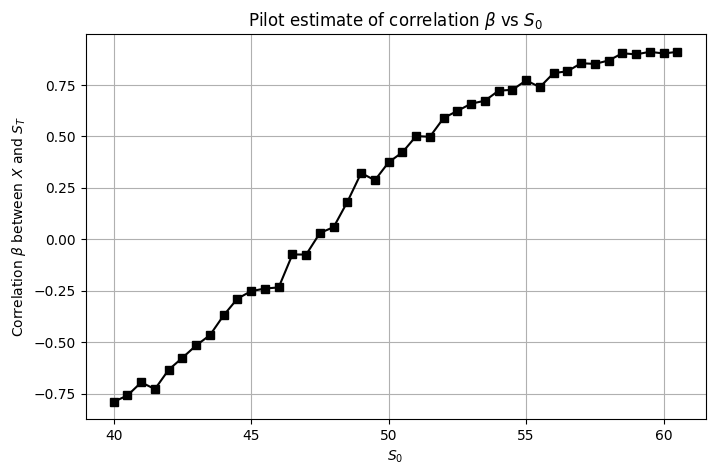

In [22]:
# Parameters
S0_values = np.arange(40, 61, 0.5)
r, sig, K, T = 0.02, 0.2, 50, 1
N_pilot = 2000  # pilot sample size

beta_list = []

for S_0 in S0_values:
    # Generate pilot sample
    Z = np.random.normal(0, 1, N_pilot)
    S_t = final_stock_price(S_0, r, sig, T, Z)
    X = np.maximum(S_t - K, 0) + np.maximum(K - S_t, 0)  # |S_T - K|
    Y = S_t

    # Correlation
    beta = np.corrcoef(X, Y)[0, 1]
    beta_list.append(beta)

# Convert to numpy array for plotting
beta_array = np.array(beta_list)

# Plot beta vs S_0
plt.figure(figsize=(8,5))
plt.plot(S0_values, beta_array, color='black', marker='s')

plt.xlabel('$S_0$')
plt.ylabel('Correlation $\\beta$ between $X$ and $S_T$')

plt.title('Pilot estimate of correlation $\\beta$ vs $S_0$')

plt.grid()

plt.show()

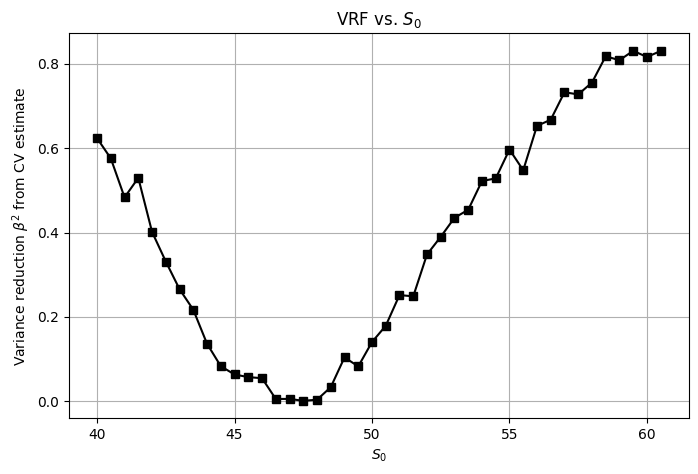

In [23]:
vrf = beta_array**2

# Plot vrf vs S_0
plt.figure(figsize=(8,5))
plt.plot(S0_values, vrf, color='black', marker='s')

plt.xlabel('$S_0$')
plt.ylabel('Variance reduction $\\beta^2$ from CV estimate')

plt.title('VRF vs. $S_0$')

plt.grid()

plt.show()